## Are there statistical links between the direction of European weather systems and ENSO, the solar cycle or stratospheric aerosols? ##

Code by [Benjamin A. Laken](http://www.benlaken.com), from work published in the journal [Royal Society Open Science](http://rsos.royalsocietypublishing.org/content/3/2/150320). Published 17 February 2016. DOI: 10.1098/rsos.150320.

## Abstract ##

The Hess Brezowsky Großwetterlagen (HBGWL) European weather classification system, accumulated over a long period (more than 130 years), provides a rare opportunity to examine the impact of various factors on regional atmospheric flow. We have used these data to examine changes in the frequency (days/month) of given weather systems direction (WSD) during peak phases in the North Atlantic Oscillation (NAO), El Niño Southern Oscillation (ENSO), solar cycle (SC) and peaks in stratospheric aerosol optical depth (AOD) with superposed epoch analysis and Monte Carlo significance testing. We found highly significant responses to the NAO consistent with expectations: this signal confirmed the utility of the HBGWL data for this type of analysis and provided a benchmark of a clear response. WSD changes associated with ENSO, SC and AOD were generally within the ranges expected from random samples. When seasonal restrictions were added the results were similar, however, we found one clearly significant result: an increase in southerly flow of $2.6\pm0.8$ days/month ($p=1.9\times10^{−4}$) during boreal summertime in association with El Niño. This result supports the existence of a robust teleconnection between the ENSO and European weather.


### Data Sources ###

Hess Brezowsky Großwetterlagen weather types, a subjective classification of synoptic-scale weather using meteorological sites across Germany, originally from [Hess, Paul and Brezowsky, Helmuth, Großwetterlagen Europas 1881-1992. 4., vollständig neu bearbeitete Auﬂage, Ber. Dt. Wetterd. 113, 1993, 5](http://www.dwd.de/bvbw/generator/DWDWWW/Content/Oeffentlichkeit/KU/KUPK/Schulen/Klima/Begriffe/Gro_C3_9Fwetterlagen__Katalog,templateId=raw,property=publicationFile.pdf/Gro&#223;wetterlagen_Katalog.pdf).

Sunspot data from the [World Data Center SILSO](http://sidc.be/silso/home), Royal Observatory of Belgium, Brussels.

Stratospheric aerosol data from [NASA](http://data.giss.nasa.gov/modelforce/strataer).

MEI (ENSO) data from [NOAA](http://www.esrl.noaa.gov/psd/enso/mei.ext/), credit Dr Klaus Wolter.

NAO data from [CRU](http://www.cru.uea.ac.uk/timo/datapages/naoi.htm/).

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import datetime as dt
from tabulate import tabulate
from scipy import stats
from calendar import monthrange
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import HBGWL_functions as hbgwl    # Custom functions from local .py file
sns.set_style("whitegrid") # Set a light Seaborn grid style

mc_iterations = 10000  # Set here how many iterations in each Monte Carlo...

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Reproducibility notes ###

This notebook is accompanied by an [`environment.yml`](environment.yml) file that can be used to create a conda environment to replicate as much as possible the results herein. The accompanying [Makefile](Makefile) provides a command to create the conda environment and one to run the notebook in a headless fashion.  This will not produce a perfectly unchanging output, but few significant differences should be visible. The remaining differences are:

- Matplotlib, as of the version used in this project (1.5.0), embeds timestamps in generated PDF figures.  [This can now be controlled, starting with version 2.1.0](https://matplotlib.org/users/whats_new.html#reproducible-ps-pdf-and-svg-output).

- Matploblib embeds the memory address of figures in the output that is stored internally in the notebook, and these are for all intents and purposes random from run to run. Changing this is [currently under discussion with the Matplotlib team](https://github.com/matplotlib/matplotlib/issues/9372).

- The Seaborn `corrplot` call, when it includes statistical significance markers (the default), produces those markers via a bootstrap computation whose random seed can *not* be set via the `corrplot` call. This means that the `*` markers in the resulting plot may vary from run to run for a few values that are right at threshold between significance levels.  The only way to avoid this would be to pass `sig_stars=False` to the corrplot() call, but the published figure had significance markers, so we leave this as-is.  We note that `corrplot` has, in newer versions of Seaborn, been removed from the library, so alternate code using `heatmap` will need to be used in the future.

- For other processes with random numbers, we set both the Python and Numpy global seeds below.

- For readability/portability reasons, we include an explicit [`watermark`](https://github.com/rasbt/watermark) call here, which can aid in having the right versions of all the tools here if this notebook is used without its accompanying `environment.yml` file.

- The output of `hbgwl.season_climatology(monthlywind, chatty=True)` is a dictionary, so the order of the main blocks may vary from run to run or if changing systems.  The actual data within each block should remain constant.


If you want to compare the state of this notebook with the result of running `make`, which will produce a new one titled `HBGWL_analysis.nbconvert.ipynb`, you can install [nbdime](https://github.com/jupyter/nbdime) and run the command:

```
nbdiff-web HBGWL_analysis.ipynb HBGWL_analysis.nbconvert.ipynb 
```

which will open a graphical diff viewer in your browser.  This will make it much easier to check whether any differences in output are meaningful or not.

In [2]:
%load_ext watermark
%watermark -vm -p numpy,scipy,pandas,statsmodels,patsy,matplotlib,seaborn,tabulate

CPython 3.4.4
IPython 5.1.0

numpy 1.10.4
scipy 0.17.1
pandas 0.17.1
statsmodels 0.6.1
patsy 0.4.1
matplotlib 1.5.0
seaborn 0.6.0
tabulate 0.8.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [3]:
# Set the random seeds
import random
random.seed(1234)
np.random.seed(1234)

### 1. Load and examine HBGWL data ###
Start out by reading the data from a text file into a pandas data-frame object, create a time axis, then distinguish the wind direction from the weather type. From a this, monthly frequencies by an 8-point compass are calculated. The statistics (time series, climatology,  distribution, and cross-correlation) of these data are then examined.

In [4]:
# Read data into Pandas table and set time index
data = pd.read_table('Data/HB_data.txt')
dtindex = pd.date_range('18810101', '20001231', freq='D') 
data.index = dtindex

In [5]:
# Example of data in HB file
data.head(5)

Year  Month  Day   HB
1881-01-01  1881      1    1   HM
1881-01-02  1881      1    2   HM
1881-01-03  1881      1    3   HM
1881-01-04  1881      1    4   HM
1881-01-05  1881      1    5  HNA

In [6]:
# Set dictionaries for wind direction, and relation to HB codes
winds = ['N','NE','E','SE','S','SW','W','NW']
wind_lookup = hbgwl.getWindDic()  

# Create 8 x n list set to 1 when the HB is a given direction
tmp_hold =[]
for day in dtindex:
    tmp = list(np.zeros([8]))
    for n,wind in enumerate(winds):
        if data.HB[day] in wind_lookup[wind]:
            tmp[n] = 1.
    tmp_hold.append(tmp)
dailywind = pd.DataFrame(data=tmp_hold,index=dtindex,columns=winds)

# Resample data to monthly timescales
monthlywind = dailywind.resample(rule='M',how='sum')

In [7]:
# Example of the data in the monthly dataframe
monthlywind.head(5)

N  NE  E  SE  S  SW  W  NW
1881-01-31   9   0  0   0  0   0  5   0
1881-02-28   4   0  8   0  6   0  4   6
1881-03-31   6   0  4   3  6   0  7   0
1881-04-30  13   0  9   0  0   0  3   0
1881-05-31  10   0  7   0  0   0  6   1

### Simple time series of wind frequency by month ###

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


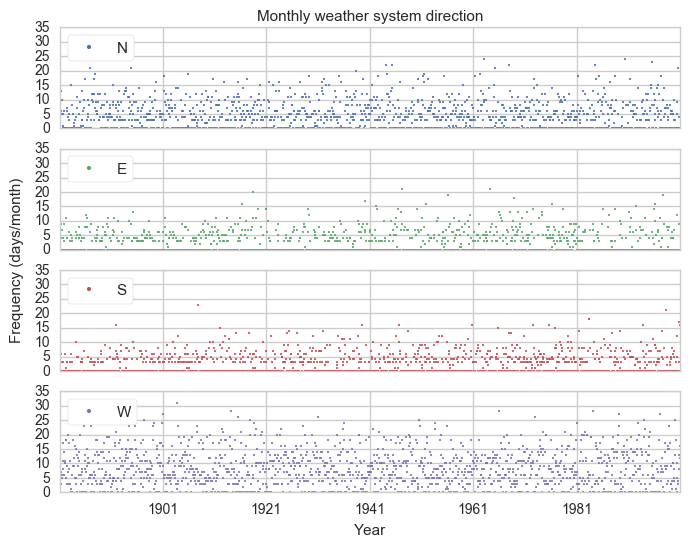

In [8]:
hbgwl.figure_MonthlyTS(df=monthlywind)

### Seasonal climatology ###
Show a violin plot of frequency (day/month) over the cardinal directions, for DJF, MAM, JJA, SON groups.

In [9]:
# Show the mean and error for seasonal climatology
tmp = hbgwl.season_climatology(monthlywind, chatty=True)

Mean (μ) and SEM frequency (days/month) by Season
For DJF
|------->N   3.49μ, 0.23sem
|------->NE  0.75μ, 0.10sem
|------->E   2.48μ, 0.21sem
|------->SE  1.51μ, 0.15sem
|------->S   2.08μ, 0.16sem
|------->SW  1.83μ, 0.17sem
|------->W   9.16μ, 0.36sem
|------->NW  2.44μ, 0.19sem
For SON
|------->N   4.22μ, 0.24sem
|------->NE  0.74μ, 0.09sem
|------->E   1.91μ, 0.16sem
|------->SE  1.33μ, 0.14sem
|------->S   2.99μ, 0.21sem
|------->SW  1.73μ, 0.16sem
|------->W   8.55μ, 0.32sem
|------->NW  2.02μ, 0.16sem
For JJA
|------->N   4.71μ, 0.25sem
|------->NE  2.02μ, 0.18sem
|------->E   1.73μ, 0.16sem
|------->SE  0.14μ, 0.04sem
|------->S   2.26μ, 0.17sem
|------->SW  0.84μ, 0.11sem
|------->W   9.15μ, 0.32sem
|------->NW  3.52μ, 0.22sem
For MAM
|------->N   5.63μ, 0.28sem
|------->NE  1.77μ, 0.15sem
|------->E   3.36μ, 0.22sem
|------->SE  1.39μ, 0.14sem
|------->S   2.76μ, 0.19sem
|------->SW  1.22μ, 0.13sem
|------->W   6.36μ, 0.28sem
|------->NW  2.24μ, 0.18sem


/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


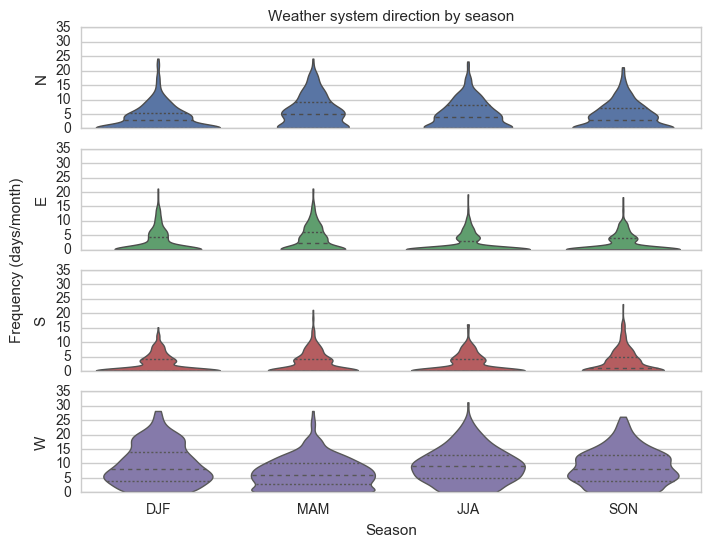

In [10]:
hbgwl.figure_seasons(data=monthlywind)

This can be shown another way below, however we have used the violin plot in the manuscript as the polar plot may give the false impression that these metrics relate to surface winds with a specific direction as viewed by an observing site (while they actually relate to the origin of regional-scale weather systems estimated over a large area). 

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


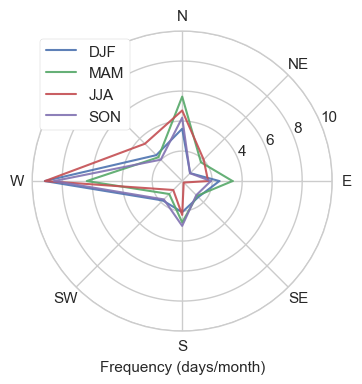

In [11]:
hbgwl.figure_SeasonalClimo(data=monthlywind)

### Distribution of data ###
A kernel density estimate and cumulative density function courtesy of the Seaborn library

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


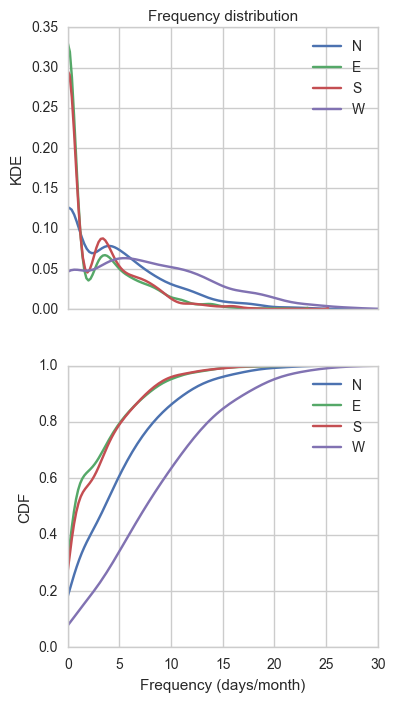

In [12]:
hbgwl.fig_distribution(data=monthlywind)

### Correlation Matrix ###
Correlation matrix of monthly wind frequency (courtesy of the Seaborn library)

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


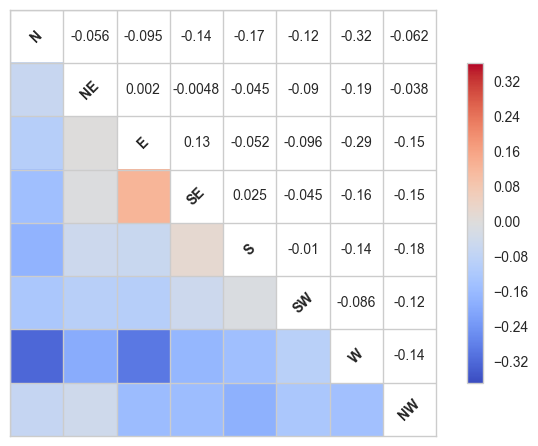

In [13]:
# Incase the sns.corrplot() becomes depreciated, you can use the heatmap commented below
#corrmat = monthlywind.corr()
#mask = np.zeros_like(corrmat, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True, mask=mask, annot=True)

sns.corrplot(monthlywind, sig_stars=False)
plt.savefig("Figs/correlation_matrix.pdf",dpi=300, bbox_inches='tight')
plt.show()

### Deseasonalise the wind data using calendar means ###

In [14]:
# Use list comprehension to calculate a climatological mean for each direction
# for each month, and then subtract each data point from this climatology.
wind_anom = {}

for key in monthlywind.keys():  # for every wind direction
    # First make a dictionary of month : mean
    tmp = [np.mean(monthlywind[key][monthlywind.index.month == n]) for n in range(1,13)]
    climatology={}
    for n, mnth in enumerate(range(1,13)):
        climatology[mnth] = tmp[n]
    # Then use the dictionary mean to de-seazonalise the data
    tmp = []
    for ind,n in enumerate(monthlywind.index.month):
        tmp.append(monthlywind[key][ind] - climatology[n])
    wind_anom[key] = tmp

# Finally, put the data back into a dataframe
deseasonWind = pd.DataFrame(wind_anom["N"],index=monthlywind.index,columns=["N"])
for key in ["NE","E","SE","S","SW","W","NW"]:
    deseasonWind[key] = wind_anom[key]

In [15]:
# Check the correlations of the de-seazonalised anomaly 
#sns.corrplot(deseasonWind)

## 2. Load data for solar activity NAO, and ENSO index ##
Load the solar and ENSO index data, and extract the samples that represent the most extreme phases of activity.

### First up, the Wolf Sunspot number ###
>https://en.wikipedia.org/wiki/Wolf_number

>http://www.ngdc.noaa.gov/stp/solar/ssn.html

In [16]:
# Read Wolf sunspot number from a text file
wolf_data = pd.read_table('Data/Solar_data.txt')

# Create a time-axis based on integer YYYY MM DD values
def gen_time(n,data):
    return pd.datetime(data.Year[n],data.Month[n],data.Day[n])
dtindex = [gen_time(n=n,data=wolf_data) for n in range(len(wolf_data))]

# Add the time axis to the arra
wolf_data.index = dtindex

# Display a preview of the daily data
print("Data runs from {0} untill {1}".format(wolf_data.index[0].date(),
                                             wolf_data.index[-1].date()))
wolf_data.head(5)

Data runs from 1881-01-01 untill 2012-10-31


Year  Month  Day  Wolf
1881-01-01  1881      1    1    40
1881-01-02  1881      1    2    51
1881-01-03  1881      1    3    39
1881-01-04  1881      1    4    41
1881-01-05  1881      1    5    15

In [17]:
# Drop the integer dates, convert to monthly resolution, and preview
wolf_data = wolf_data.drop(["Year","Month","Day"],axis=1)
monthlyWolf = wolf_data.resample(rule='M',how='mean')
monthlyWolf.head(5)

Wolf
1881-01-31  36.354839
1881-02-28  53.178571
1881-03-31  51.451613
1881-04-30  51.633333
1881-05-31  43.548387

### NAO index ###
Updated NAO index from <a href="http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1097-0088(19971115)17:13%3C1433::AID-JOC203%3E3.0.CO;2-P/abstract;jsessionid=F9633DF7DE9627A59AF0E3CACF95B86B.f04t04" target="_blank">Jones et al (1997)</a>, taken from <a href="http://www.cru.uea.ac.uk/~timo/datapages/naoi.htm" target="_blank">Tim Osborn's site</a>. 

Data has been converted to Pandas DF and pickled, for convenient reading.

In [18]:
# nb. Data has 16 missing values (all before 1825 so no problem as not used)
monthlyNAO = pd.read_pickle("Data/nao_pandas")

### ENSO (MEI) index data ###

http://www.esrl.noaa.gov/psd/enso/mei.ext/

http://www.esrl.noaa.gov/psd/enso/mei.ext/table.ext.html

In [19]:
# Read in MEI data
monthlyMEI = pd.read_csv('Data/MEI_ts.txt') 

# Create a date index
def to_dt(inputstring):
    return pd.datetime(int(inputstring[0:4]),int(inputstring[5:7]),int(inputstring[8:10]))

dtlist = [to_dt(date) for date in monthlyMEI.dates]
monthlyMEI.index = dtlist
monthlyMEI = monthlyMEI.drop("dates",axis=1)

# Display a sample of the data
print("Data runs from {0} untill {1}".format(monthlyMEI.index[0].date(),
                                             monthlyMEI.index[-1].date()))
monthlyMEI.head(5)

Data runs from 1881-01-31 untill 2005-12-31


MEI
1881-01-31  0.148
1881-02-28  0.215
1881-03-31  0.174
1881-04-30  0.082
1881-05-31 -0.105

### Stratospheric Aerosol Index ###
Read in Stratospheric Aerosol index data obtained from [NASA](http://data.giss.nasa.gov/modelforce/strataer/).

In [20]:
sato_df = pd.read_pickle("Data/sato_index")

In [21]:
sato_df.head()

NHemi_AOD
1850-01-31     0.0044
1850-02-28     0.0042
1850-03-31     0.0040
1850-04-30     0.0039
1850-05-31     0.0037

### Combine dataframes into one object ###

In [22]:
print("Samples run for time range {0} to {1} ({2} time-points)".format(
        min(monthlywind.index.date),max(monthlywind.index.date),len(monthlywind)))

# Data munging: For the start and end point of the wind data...
start = min(monthlywind.index.date)
end = max(monthlywind.index.date)

#...trim the data so everything matches.
monthlyMEI = monthlyMEI[start:end]
monthlyNAO = monthlyNAO[start:end]
monthlyWolf = monthlyWolf[start:end]
sato_df = sato_df[start:end]

# Create a unified Dataframe to work from
df = pd.concat([deseasonWind, monthlyNAO, monthlyMEI, monthlyWolf, sato_df],axis=1)
print("Deseazonalised monthly wind frequency, Wolf number and MEI combined to one object (df).")

Samples run for time range 1881-01-31 to 2000-12-31 (1440 time-points)
Deseazonalised monthly wind frequency, Wolf number and MEI combined to one object (df).


In [23]:
df.head()

N        NE         E        SE         S        SW  \
1881-01-31  5.575000 -0.858333 -2.675000 -1.616667 -1.950000 -2.275000   
1881-02-28  0.108333 -0.816667  5.150000 -1.591667  4.141667 -1.400000   
1881-03-31  1.441667 -1.316667  0.858333  1.083333  3.825000 -1.233333   
1881-04-30  6.816667 -1.741667  6.050000 -1.250000 -3.016667 -1.175000   
1881-05-31  3.850000 -2.250000  3.016667 -1.016667 -3.083333 -1.258333   

                   W        NW   NAO    MEI       Wolf  NHemi_AOD  
1881-01-31 -4.216667 -2.558333 -3.60  0.148  36.354839     0.0014  
1881-02-28 -3.366667  3.708333 -1.62  0.215  53.178571     0.0014  
1881-03-31 -1.016667 -2.675000 -0.51  0.174  51.451613     0.0013  
1881-04-30 -2.758333 -2.258333 -1.42  0.082  51.633333     0.0012  
1881-05-31  0.691667 -0.791667  0.82 -0.105  43.548387     0.0011

### Display the forcing time series data ###

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


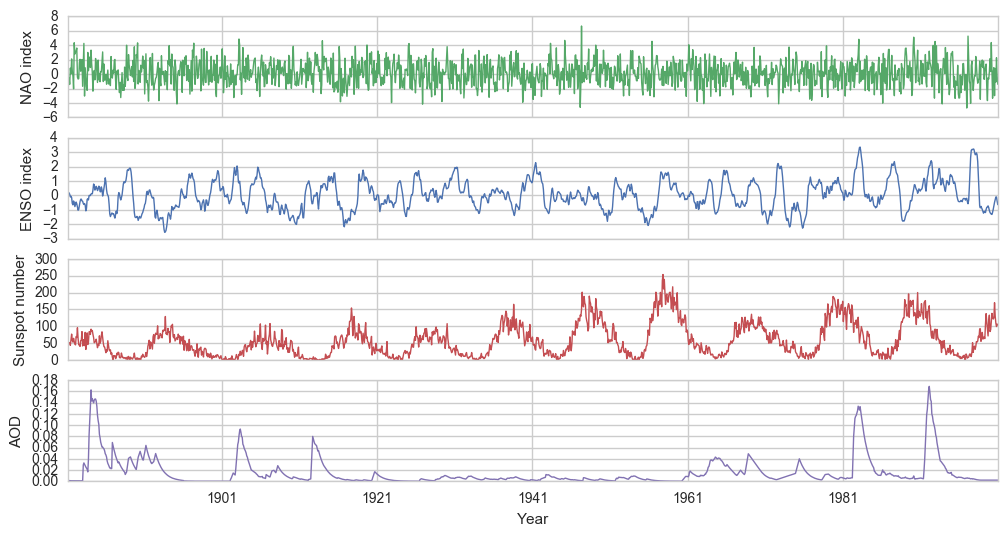

In [24]:
hbgwl.figure_forcing_TS(data=df)

## 3. Identify peak forcing periods as the basis for constructingcomposite samples ##
There have been approximately 11 solar cycles over the available data period. Using the most statistically extreme phases of the ENSO index and solar cycle identify composite samples based on n=11 observations.

### Identify extremes of NAO and ENSO and AOD ###
Use a custom function to filter the most extreme dates to remove overlap within a period of 365 days. Use the top 11 dates as the sample. (11 matches number of complete solar cycles over the period).

In [25]:
ensoPhase = hbgwl.gen_keydates(df=df, key="MEI", no_overlap_prd=365)

/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:210: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(key, ascending=phase).head(600).index, prd = no_overlap_prd)


Reduced 600 to 54 non-overlapping dates in ±365 dy prd
Reduced 600 to 50 non-overlapping dates in ±365 dy prd
Average for max/min sample of MEI: 2.315 and -2.013


/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:213: FutureWarning: order is deprecated, use sort_values(...)
  compPhase['max'] = tmpvals[0][0:11].order()
/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:214: FutureWarning: order is deprecated, use sort_values(...)
  compPhase['min'] = tmpvals[1][0:11].order()


In [26]:
naoPhase = hbgwl.gen_keydates(df=df, key="NAO", no_overlap_prd=365)

/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:210: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(key, ascending=phase).head(600).index, prd = no_overlap_prd)


Reduced 600 to 82 non-overlapping dates in ±365 dy prd
Reduced 600 to 83 non-overlapping dates in ±365 dy prd
Average for max/min sample of NAO: 4.888 and -4.149


/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:213: FutureWarning: order is deprecated, use sort_values(...)
  compPhase['max'] = tmpvals[0][0:11].order()
/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:214: FutureWarning: order is deprecated, use sort_values(...)
  compPhase['min'] = tmpvals[1][0:11].order()


In [27]:
# Note that it only makes sense to use 'max' dictionary object (AOD peaks)
# also, see the overlap period is extended so as not to draw dates from the
# same volcanic erruption periods. 
aod_peak = hbgwl.gen_keydates(df=df, key="NHemi_AOD", no_overlap_prd=365*5)

Reduced 600 to 13 non-overlapping dates in ±1825 dy prd


/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:210: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(key, ascending=phase).head(600).index, prd = no_overlap_prd)


Reduced 600 to 15 non-overlapping dates in ±1825 dy prd
Average for max/min sample of NHemi_AOD: 0.077 and 0.001


/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:213: FutureWarning: order is deprecated, use sort_values(...)
  compPhase['max'] = tmpvals[0][0:11].order()
/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:214: FutureWarning: order is deprecated, use sort_values(...)
  compPhase['min'] = tmpvals[1][0:11].order()


### Use the historical max/min of the 11 Solar Cycles of data ###
Construct a dictionary solarPhase, containing the centre of each solar maximum and minimum over the data period, determined from NOAA dates.

In [28]:
solarPhase ={}

solarPhase["max"] = [pd.datetime(1883,11,30),
        pd.datetime(1894,1,31),
        pd.datetime(1907,1,31),
        pd.datetime(1917,7,31),
        pd.datetime(1928,5,31),
        pd.datetime(1937,5,31),
        pd.datetime(1947,6,30),
        pd.datetime(1957,11,30),
        pd.datetime(1968,11,30),
        pd.datetime(1979,11,30),
        pd.datetime(1989,7,31)]

solarPhase["min"] = [pd.datetime(1889,7,31),
        pd.datetime(1901,8,31),
        pd.datetime(1913,7,31),
        pd.datetime(1923,7,31),
        pd.datetime(1933,10,31),
        pd.datetime(1944,2,29),
        pd.datetime(1954,4,30),
        pd.datetime(1964,11,30),
        pd.datetime(1976,6,30),
        pd.datetime(1986,10,31),
        pd.datetime(1996,11,30)]

### Show a composite of the forcings over a long time-period for discussion ###

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


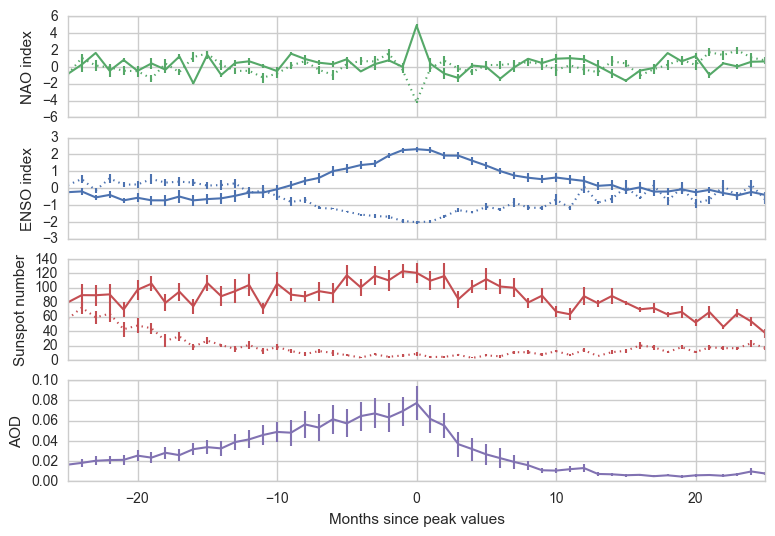

In [29]:
# Use a function to composite the forcings
hbgwl.fig_forcing_composite(df=df, naoPhase=naoPhase,
                            ensoPhase=ensoPhase, solarPhase=solarPhase, aod_peak=aod_peak)

### Use a Monte Carlo to identify sample distributions###

For further details about the particulars of the Monte Carlo approach used here see [Laken & Calogovic, 2012](http://www.swsc-journal.org/articles/swsc/abs/2013/01/swsc130020/swsc130020.html).

The raw MC-array (random values generated) are exposed below as the mc_array pandas Dataframe.

In [30]:
# Generate a dataframe holding the random MC values
mc_array = {}
keys=["N","NE","E","SE","S","SW","W","NW"]
for n, key in enumerate(keys):
    hbgwl.status(current=n, end_val=len(keys)-1, key=key)
    mc_array[key] = hbgwl.monteCarlo(df=df, its=mc_iterations, show_kde=False, key=key, give_array=True)
mc_array = pd.DataFrame(data=mc_array)

MC progress: [####################] 100% (NW)

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


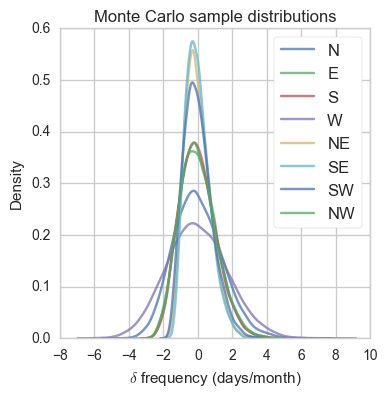

In [31]:
# Show the KDE of the monte carlo distributions for each wind direction
hbgwl.figure_montecarlo_kde(mc_array=mc_array)

Extract confidence intervals for each direction using percentile values to create a pd.Dataframe of confidence intervals (column, indicated by percentile) per wind direction (row)

In [32]:
keys=["N","NE","E","SE","S","SW","W","NW"]
confs ={}
percentiles=[0.5,2.5,5,50,95,97.5,99.5]
for key in keys:
    confs[key] = {pcn: stats.scoreatpercentile(mc_array[key], pcn) for pcn in percentiles}
conf_df = hbgwl.extractConfsByDirection(data=confs)
conf_df

0.5       2.5       5.0       50.0      95.0      97.5      99.5
N  -3.140163 -2.490928 -2.145758 -0.088636  2.436477  2.964451  4.137909
NE -1.446235 -1.214413 -1.068939 -0.101515  1.373636  1.693258  2.359102
E  -2.203068 -1.828106 -1.606136 -0.066288  1.893939  2.315208  3.224409
SE -1.303053 -1.112159 -0.994735 -0.090530  1.319735  1.640189  2.222769
S  -2.214413 -1.787140 -1.556061 -0.081061  1.867424  2.275777  3.097799
SW -1.485610 -1.293996 -1.162159 -0.085227  1.540227  1.888655  2.562144
W  -4.265212 -3.320511 -2.844053 -0.094318  2.935606  3.562955  4.611432
NW -2.258348 -1.850076 -1.583371 -0.082955  1.915909  2.348504  3.203163

## Plot composites ##

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


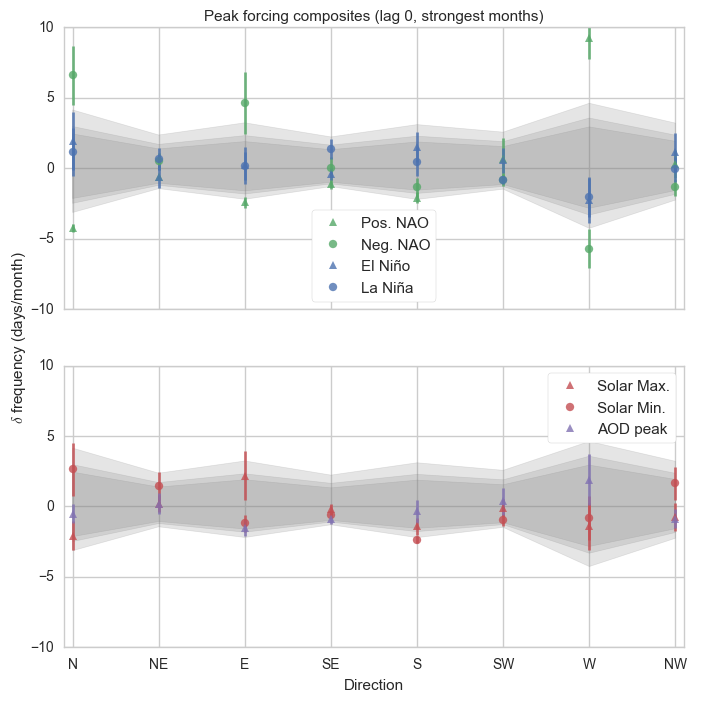

In [33]:
hbgwl.figHorizCompOnePrd(df=df, conf_df= conf_df, naoPhase=naoPhase, aod_peak=aod_peak,
                          solarPhase=solarPhase, ensoPhase=ensoPhase, epoch=0, giveYrange=(-10,10))

In the above figure, the composites the diffrent differnt wind origin directions have been ordered on the x-axis, with their seasonal anomalies during various forcing peaks on the y-axis. Uncertainty is shown in Standard Error of the Mean (SEM). The grey shading indicates the confidence interval, derrived from MC-iterations. The first interval shows the 95th percentile range, the second shows the range from the 95th to 97.5th and the third shows the 97.5th to the 99.9th confidence range.

These data are formatted in a diffrent way below, to show more simultaneous info and also a range of positive and negative monthly-timescale lags.

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


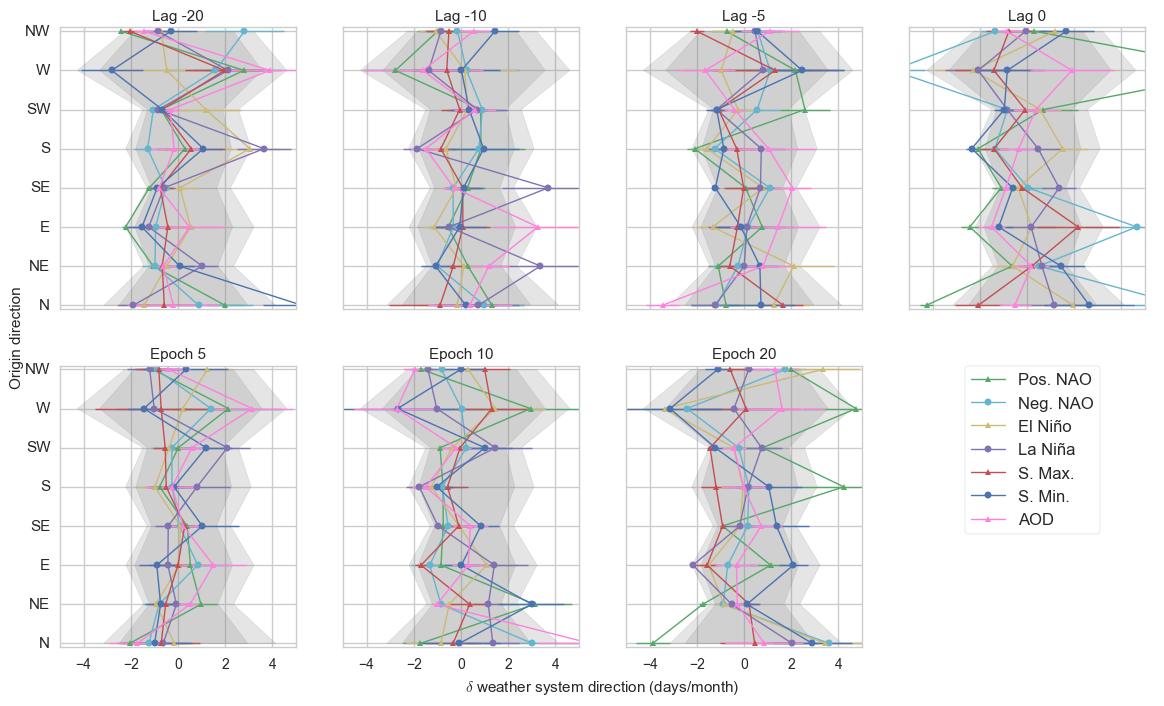

In [34]:
hbgwl.figure_composite_complex(df=df, conf_df=conf_df, ensoPhase=ensoPhase, aod_peak=aod_peak,
                                naoPhase=naoPhase, solarPhase=solarPhase)

### Estimate the specific p-values of a specified epoch ###

Each time this is run the values will be slightly different, particularly for values at tails of the distributions, as the probabilities are estimated from KDEs built from Monte Carlo samples. The amount of difference depends on the convergence of the Monte Carlo distributions, which will be more similar the larger the number of iterations. For further discussion and details of MC convergence and its impact on probability estimation see my work in <a href="http://www.swsc-journal.org/articles/swsc/abs/2013/01/swsc130020/swsc130020.html" target="_blank">Laken & Calogovic (2012)</a>.

In [35]:
monthly_sig_table = hbgwl.get_pTable(df=df, mc=mc_array, aod_peak=aod_peak, solarPhase=solarPhase,
                      naoPhase=naoPhase, ensoPhase=ensoPhase, epoch=0)

print(tabulate(monthly_sig_table, headers="firstrow",tablefmt='fancygrid')) #fancygrid or latex

             N           NE          E           SE          S           SW          W           NW
-----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Pos. NAO     -4.27±0.29  -0.64±0.07  -2.43±0.38  -1.10±0.41  -2.08±0.42  0.69±1.46   9.24±1.49   0.30±1.01
p-val lower  1.77E-04    0.44        6.98E-04    0.01        0.01        0.39        6.83E-05    0.34
p-val mean   3.62E-04    0.48        0.01        0.18        0.04        0.28        4.43E-07    0.32
p-val upper  0.00        0.50        0.05        0.47        0.12        0.03        3.98E-21    0.15
--           --          --          --          --          --          --          --          --
Neg. NAO     6.59±2.08   0.50±0.61   4.65±2.18   0.04±0.75   -1.36±0.65  -0.84±0.43  -5.71±1.37  -1.35±0.59
p-val lower  0.00        0.53        0.03        0.46        0.05        0.16        3.82E-07    0.06
p-val mean   7.50E-05    0.34        5.20E-04    0.53        0.20    

## 4. Further scrutiny: Do seasonal restrictions change the results? ##
### Re-bin the data to give one value per season per year, for DJF, MAM, JJA, SON periods ###
Many claims of significant associations relate to certain periods only (e.g. during N.Hemi. winter-time). Consequently, I will re-sample the data, dividing it into DJF, MAM, JJA, SON periods, and perform a comprable analysis on these data.

N.b. A slightly diffrent approach to identify the key periods to composite is needed with these new data. Simply compositing based on the previous months is not sufficent (particularly for the NAO, for example). I must identify the peaks of the 'forcing' agents associated with each seasonal time-series again. This is done by the following process:

  1. Average the de-seasonalised time-series data (both HBGWL and 'forcing' data - the latter are absoloute values) within their respective seasonal period, and thereby create four new time series, each with one value per-year (representing the seasonal mean anomaly for the HBGWL and mean over the seasonal period for the forcing data).
  2. Identify the highest/lowest values in the forcing data within the new time-series. For the solar forcing, these values must not reoccur within a ±5 year period, so as to iscolate only one peak per solar cycle. For the other data the non-reccurance period is only ±1 year, so as to minimise loss of potential signal from autocorrelation in the climate data.
  3. Perform statistical analysis as before.

In [36]:
djf_frame = hbgwl.getSeasonalFrame(data=df, season="DJF")
mam_frame = hbgwl.getSeasonalFrame(data=df, season="MAM")
jja_frame = hbgwl.getSeasonalFrame(data=df, season="JJA")
son_frame = hbgwl.getSeasonalFrame(data=df, season="SON")

In [37]:
djf_frame.head(5)

N     N_SEM        NE    NE_SEM         E     E_SEM        SE  \
1881 -3.486111  0.218652 -0.747222  0.091076 -2.480556  0.286435 -1.513889   
1882 -3.486111  0.218652 -0.080556  0.757040 -1.480556  0.942125  4.152778   
1883 -1.783333  1.160834 -0.712500  0.103120 -2.295833  0.268111 -1.475000   
1884 -3.152778  0.154060  1.586111  1.241250 -1.480556  0.942125  2.486111   
1885 -3.486111  0.218652  0.586111  1.301338  4.186111  3.245026 -0.180556   

        SE_SEM         S     S_SEM      ...              NW    NW_SEM  \
1881  0.090566 -0.075000  1.829358      ...        0.225000  2.741772   
1882  3.024569  0.925000  1.766791      ...        1.225000  2.103062   
1883  0.100173 -2.183333  0.164992      ...        5.983333  1.797230   
1884  2.303954 -0.075000  1.171132      ...       -2.108333  0.325889   
1885  1.297026 -2.075000  0.172871      ...        3.225000  2.608870   

           Wolf  Wolf_SEM       NAO   NAO_SEM       MEI   MEI_SEM  NHemi_AOD  \
1881  53.952765  7.818694  3.013333  0.127323 -0.611667  0.091189   0.001000   
1882  49.793395  5.605741  1.410000  1.719651 -0.531333  0.066456   0.020900   
1883  83.741935  5.519995  2.115000  0.852064  0.041000  0.037477   0.147800   
1884  53.929724  9.033751  0.410000  0.806990  0.556667  0.063394   0.097733   
1885  25.857911  2.356226 -0.610000  0.413280  0.470000  0.235477   0.042167   

      NHemi_AOD_SEM  
1881       0.000000  
1882       0.010107  
1883       0.010607  
1884       0.007182  
1885       0.003132  

[5 rows x 24 columns]

In [38]:
# Uncomment the below to display a figure of the winter-time δ weather system origin
#hbgwl.figure_djf_ts(df=djf_frame)

In [39]:
# Uncomment below to see DJF avearged data for forcing parameters 
#hbgwl.figure_forcing_TS(data=djf_frame, fnm="DJF_forcing.pdf")

### Identify extreme samples for composite ###
Rank the data, take samples of n=11 (non-overlapping within ±5yr period) for minima/maxima as a basis for composites

In [40]:
def gen_dic(key):
    """ Generate a dic. of max/min phase dates, with a key for each season and key for max/min."""
    tmp ={}
    for szn, frame in zip(['DJF','MAM','JJA','SON'],[djf_frame, mam_frame, jja_frame, son_frame]):
        tmp[szn] = hbgwl.gen_keydates(df=frame, key=key, seasonalData=True, chatty=False)
    return tmp

In [41]:
seasonal_NAO_keys = gen_dic(key="NAO")
seasonal_ENSO_keys = gen_dic(key="MEI")
seasonal_SC_keys = gen_dic(key="Wolf")
seasonal_aodPeak_keys = gen_dic(key="NHemi_AOD")

/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:206: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(key, ascending=phase).head(600).index, key=key)
/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:213: FutureWarning: order is deprecated, use sort_values(...)
  compPhase['max'] = tmpvals[0][0:11].order()
/Users/fperez/teach/berkeley/2017-stat159/repro-papers/European_wind/HBGWL_functions.py:214: FutureWarning: order is deprecated, use sort_values(...)
  compPhase['min'] = tmpvals[1][0:11].order()


In [42]:
print("E.g. of the integer years to use as index for the DJF composites:")
print('Sato   ', seasonal_aodPeak_keys['DJF']['max'].values)
print('El Nino', seasonal_ENSO_keys['DJF']['max'].values)
print('La Nina', seasonal_ENSO_keys['DJF']['min'].values)
print('Pos NAO', seasonal_NAO_keys['DJF']['max'].values)
print('Neg NAO', seasonal_NAO_keys['DJF']['min'].values)
print('SC max ', seasonal_SC_keys['DJF']['max'].values)
print('SC min ', seasonal_SC_keys['DJF']['min'].values)

E.g. of the integer years to use as index for the DJF composites:
Sato    [1883 1890 1902 1912 1920 1942 1962 1968 1974 1982 1991]
El Nino [1888 1918 1925 1930 1957 1965 1972 1982 1987 1991 1997]
La Nina [1886 1889 1892 1909 1916 1950 1955 1970 1973 1975 1988]
Pos NAO [1881 1883 1893 1902 1919 1924 1931 1936 1948 1988 1994]
Neg NAO [1894 1916 1935 1939 1946 1962 1964 1968 1976 1978 1995]
SC max  [1883 1893 1917 1926 1936 1948 1957 1967 1979 1988 1999]
SC min  [1889 1900 1911 1923 1933 1943 1953 1963 1975 1986 1996]


### Identify the confidence intervals using MC###
#### A note on units and error####
The values have gone from monthly frequency (day/months), to deseazonalised ($\delta$) mean wintertime (DJF) frequency (days/month) with uncertainty measured in ±1 standard error of the mean ($SEM=\frac{\sigma}{\sqrt(n-1)}$), where $\sigma$ is sample standard deviation, and $n$ is the number of months (3) which comprise the season. 

In compositing the DJF data I have accumulated the mean uncertainty as $\frac{1}{n}\sqrt{\displaystyle\sum_{i=1}^n(SEM_i)^2}$, where $n$ is the number of key dates in the composite (in this case 11).

In [43]:
# Generate a dataframe holding the random MC values for DJF and extract the confidence intervals
# Start with DJF period
mc_array_djf = {}
keys=["N","NE","E","SE","S","SW","W","NW"]
for n, key in enumerate(keys):
    hbgwl.status(current=n, end_val=len(keys)-1, key=key)
    mc_array_djf[key] = hbgwl.monteCarlo(df=djf_frame, its=mc_iterations, show_kde=False,
                                         key=key, give_array=True)
mc_array_djf = pd.DataFrame(data=mc_array_djf)

confs_djf ={}
percentiles=[0.5,2.5,5,50,95,97.5,99.5]
for key in keys:
    confs_djf[key] = {pcn: stats.scoreatpercentile(mc_array_djf[key], pcn) for pcn in percentiles}
conf_df_djf = hbgwl.extractConfsByDirection(data=confs_djf)
conf_df_djf

MC progress: [####################] 100% (NW)

0.5       2.5       5.0       50.0      95.0      97.5      99.5
N  -1.873485 -1.521717 -1.324747 -0.117551  1.523737  1.853788  2.475000
NE -0.646843 -0.528867 -0.465025 -0.016793  0.580429  0.704861  0.974369
E  -1.672601 -1.340909 -1.187753 -0.100126  1.297096  1.613636  2.234848
SE -1.082593 -0.870455 -0.749419 -0.030051  0.814899  0.996806  1.348760
S  -1.382576 -1.114394 -0.978030 -0.109848  0.981061  1.208333  1.612125
SW -1.274403 -1.025631 -0.889268 -0.072980  0.889899  1.084848  1.474422
W  -2.842093 -2.215152 -1.857197  0.169318  2.330303  2.764157  3.642803
NW -1.460614 -1.181061 -1.000758 -0.053030  1.051515  1.258466  1.711371

### Plot the composite###

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


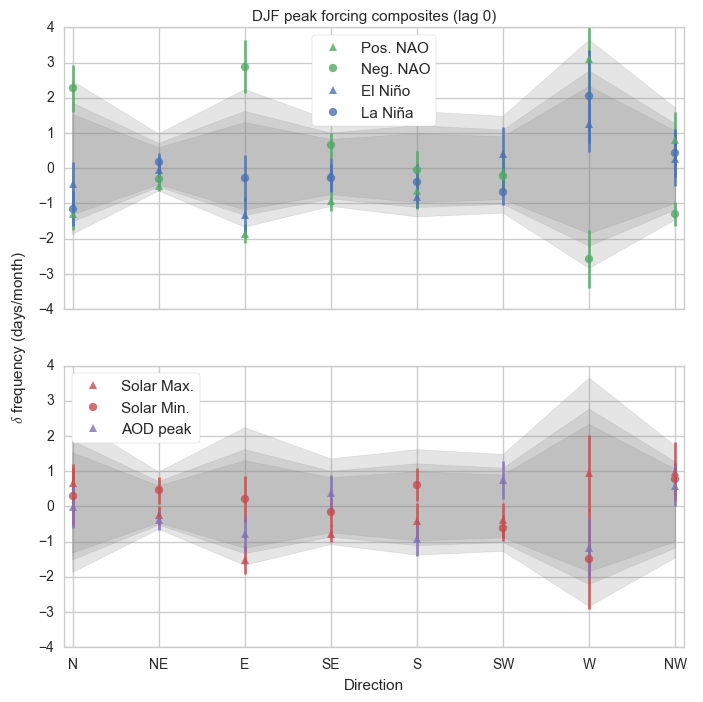

In [44]:
hbgwl.figHorizCompOnePrd(df=djf_frame, conf_df= conf_df_djf, naoPhase=seasonal_NAO_keys,
                         aod_peak=seasonal_aodPeak_keys, solarPhase=seasonal_SC_keys,
                         ensoPhase=seasonal_ENSO_keys, epoch=0, szn="DJF",  giveYrange=(-4,4))

In [45]:
djf_sig_table = hbgwl.get_pTable(df=djf_frame, mc=mc_array_djf, aod_peak=seasonal_aodPeak_keys,
                                 solarPhase=seasonal_SC_keys, naoPhase=seasonal_NAO_keys, 
                                 ensoPhase=seasonal_ENSO_keys, seasonal="DJF")

print(tabulate(djf_sig_table, headers="firstrow",tablefmt='fancygrid')) #fancygrid 

DJF          N           NE          E           SE          S           SW          W           NW
-----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Pos. NAO     -1.31±0.44  -0.51±0.13  -1.85±0.26  -0.93±0.28  -0.63±0.53  -0.10±0.55  3.10±0.98   0.80±0.79
p-val lower  0.05        0.12        0.00        0.02        0.11        0.44        0.11        0.60
p-val mean   0.17        0.33        0.01        0.13        0.50        0.72        0.03        0.25
p-val upper  0.35        0.68        0.05        0.38        0.66        0.47        0.00        0.03
--           --          --          --          --          --          --          --          --
Neg. NAO     2.27±0.67   -0.31±0.21  2.89±0.75   0.65±0.36   -0.04±0.55  -0.21±0.39  -2.58±0.83  -1.31±0.34
p-val lower  0.08        0.29        0.02        0.63        0.53        0.48        0.00        0.01
p-val mean   0.02        0.88        0.00        0.32        0.65    

## Now, repeat this for MAM, JJA, SON seasons: ##

### March April May (MAM months) ###

In [46]:
mc_array_mam = {}
keys=["N","NE","E","SE","S","SW","W","NW"]
for n, key in enumerate(keys):
    hbgwl.status(current=n, end_val=len(keys)-1, key=key)
    mc_array_mam[key] = hbgwl.monteCarlo(df=mam_frame, its=mc_iterations, show_kde=False,
                                         key=key, give_array=True)
mc_array_mam = pd.DataFrame(data=mc_array_mam)

confs_mam ={}
percentiles=[0.5,2.5,5,50,95,97.5,99.5]
for key in keys:
    confs_mam[key] = {pcn: stats.scoreatpercentile(mc_array_mam[key], pcn) for pcn in percentiles}
conf_df_mam = hbgwl.extractConfsByDirection(data=confs_mam)
#conf_df_mam

MC progress: [####################] 100% (NW)

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


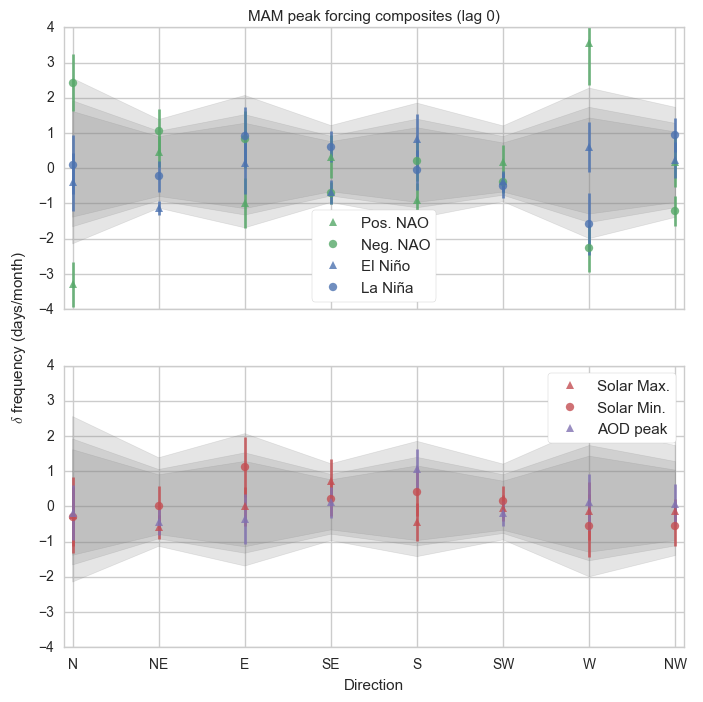

In [47]:
hbgwl.figHorizCompOnePrd(df=mam_frame, conf_df= conf_df_mam, naoPhase=seasonal_NAO_keys,
                         aod_peak=seasonal_aodPeak_keys, solarPhase=seasonal_SC_keys,
                         ensoPhase=seasonal_ENSO_keys, epoch=0, szn="MAM", giveYrange=(-4,4))

In [48]:
mam_sig_table = hbgwl.get_pTable(df=mam_frame, mc=mc_array_mam, aod_peak=seasonal_aodPeak_keys,
                                 solarPhase=seasonal_SC_keys, naoPhase=seasonal_NAO_keys, 
                                 ensoPhase=seasonal_ENSO_keys, seasonal="MAM")

print(tabulate(mam_sig_table, headers="firstrow",tablefmt='fancygrid')) #fancygrid 

MAM          N           NE          E           SE          S           SW          W           NW
-----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Pos. NAO     -3.30±0.63  0.47±0.45   -0.99±0.71  0.33±0.60   -0.91±0.48  0.17±0.49   3.55±1.19   0.18±0.72
p-val lower  1.25E-10    0.77        0.02        0.76        0.04        0.79        0.01        0.52
p-val mean   1.64E-04    0.48        0.24        0.66        0.27        0.77        1.91E-04    0.57
p-val upper  0.00        0.17        0.52        0.10        0.58        0.26        1.14E-27    0.20
--           --          --          --          --          --          --          --          --
Neg. NAO     2.43±0.80   1.05±0.62   0.82±0.81   -0.70±0.32  0.21±0.57   -0.40±0.31  -2.27±0.67  -1.21±0.43
p-val lower  0.10        0.51        0.50        0.04        0.61        0.28        4.09E-04    0.01
p-val mean   0.02        0.12        0.28        0.27        0.53    

### June July August (JJA) months ###

In [49]:
mc_array_jja = {}
keys=["N","NE","E","SE","S","SW","W","NW"]
for n, key in enumerate(keys):
    hbgwl.status(current=n, end_val=len(keys)-1, key=key)
    mc_array_jja[key] = hbgwl.monteCarlo(df=jja_frame, its=mc_iterations, show_kde=False,
                                         key=key, give_array=True)
mc_array_jja = pd.DataFrame(data=mc_array_jja)

confs_jja ={}
percentiles=[0.5,2.5,5,50,95,97.5,99.5]
for key in keys:
    confs_jja[key] = {pcn: stats.scoreatpercentile(mc_array_jja[key], pcn) for pcn in percentiles}
conf_df_jja = hbgwl.extractConfsByDirection(data=confs_jja)
conf_df_jja

MC progress: [####################] 100% (NW)

0.5       2.5       5.0       50.0      95.0      97.5      99.5
N  -1.978283 -1.524495 -1.311616 -0.069192  1.294444  1.536869  2.052020
NE -1.358333 -1.085606 -0.934091  0.005303  1.065909  1.308333  1.702273
E  -1.212626 -1.000505 -0.848990 -0.030808  0.969192  1.211616  1.575253
SE -0.141667 -0.141667 -0.141667 -0.020455  0.221970  0.282576  0.373485
S  -1.379545 -1.106818 -0.925000 -0.015909  1.075000  1.287121  1.650909
SW -0.750758 -0.659848 -0.568939 -0.084091  0.612879  0.764394  1.037121
W  -2.632071 -2.026010 -1.692677  0.034596  1.792172  2.125505  2.701263
NW -1.759091 -1.365152 -1.153030  0.028788  1.271212  1.543939  2.028788

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


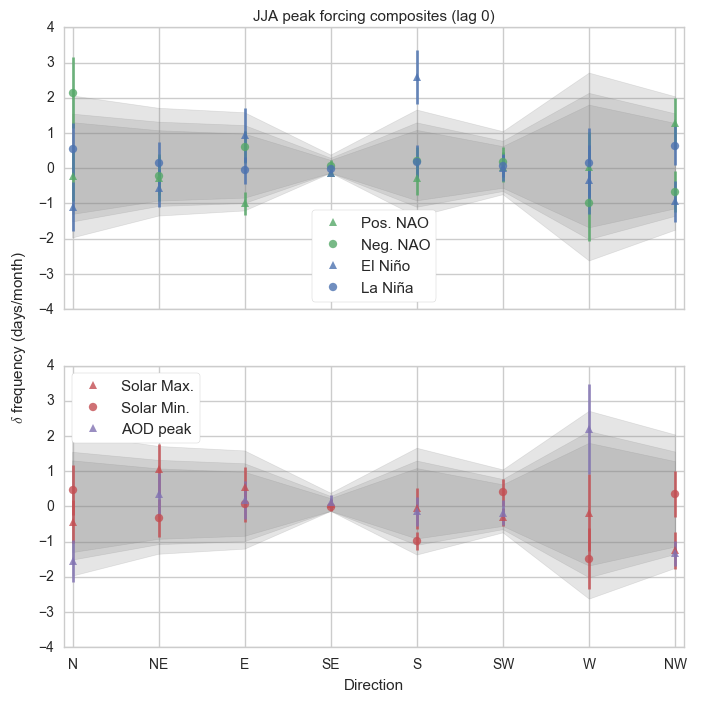

In [50]:
hbgwl.figHorizCompOnePrd(df=jja_frame, conf_df= conf_df_jja, naoPhase=seasonal_NAO_keys,
                         aod_peak=seasonal_aodPeak_keys, solarPhase=seasonal_SC_keys,
                         ensoPhase=seasonal_ENSO_keys, epoch=0, szn="JJA", giveYrange=(-4,4))

In [51]:
jja_sig_table = hbgwl.get_pTable(df=jja_frame, mc=mc_array_jja, aod_peak=seasonal_aodPeak_keys,
                                 solarPhase=seasonal_SC_keys, naoPhase=seasonal_NAO_keys, 
                                 ensoPhase=seasonal_ENSO_keys, seasonal="JJA")

print(tabulate(jja_sig_table, headers="firstrow",tablefmt='fancygrid')) #fancygrid 

JJA          N           NE          E           SE          S           SW          W           NW
-----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Pos. NAO     -0.22±0.72  -0.27±0.66  -1.00±0.34  -0.14±0.02  -0.29±0.48  0.04±0.41   0.03±1.00   1.27±0.72
p-val lower  0.28        0.20        0.02        2.94        0.32        0.86        0.25        0.41
p-val mean   0.48        0.61        0.14        5.42        0.60        0.96        0.37        0.13
p-val upper  0.38        0.49        0.39        2.94        0.58        0.40        0.25        0.02
--           --          --          --          --          --          --          --          --
Neg. NAO     2.14±1.00   -0.21±0.56  0.61±0.46   0.07±0.15   0.20±0.41   0.19±0.42   -1.00±1.06  -0.67±0.58
p-val lower  0.17        0.32        0.64        0.94        0.62        1.05        0.06        0.13
p-val mean   0.01        0.63        0.38        2.75        0.58    

### September October November (SON) months ###

In [52]:
mc_array_son = {}
keys=["N","NE","E","SE","S","SW","W","NW"]
for n, key in enumerate(keys):
    hbgwl.status(current=n, end_val=len(keys)-1, key=key)
    mc_array_son[key] = hbgwl.monteCarlo(df=son_frame, its=mc_iterations, show_kde=False,
                                         key=key, give_array=True)
mc_array_son = pd.DataFrame(data=mc_array_son)

confs_son ={}
percentiles=[0.5,2.5,5,50,95,97.5,99.5]
for key in keys:
    confs_son[key] = {pcn: stats.scoreatpercentile(mc_array_son[key], pcn) for pcn in percentiles}
conf_df_son = hbgwl.extractConfsByDirection(data=confs_son)
conf_df_son

MC progress: [####################] 100% (NW)

0.5       2.5       5.0       50.0      95.0      97.5      99.5
N  -1.861364 -1.467424 -1.255303  0.017424  1.290152  1.532576  2.017424
NE -0.647980 -0.496465 -0.435859 -0.011616  0.503535  0.594444  0.806566
E  -1.092929 -0.880808 -0.759596 -0.032323  0.816162  0.997980  1.391919
SE -0.964141 -0.782323 -0.691414 -0.024747  0.793434  0.975253  1.308586
S  -1.595101 -1.322222 -1.140404 -0.110101  1.071717  1.314141  1.768687
SW -1.124495 -0.912374 -0.791162 -0.003283  0.937626  1.178535  1.572626
W  -2.698737 -2.062374 -1.759343 -0.032071  1.786111  2.149747  2.786111
NW -1.168182 -0.925758 -0.804545 -0.016667  0.953030  1.134848  1.468182

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


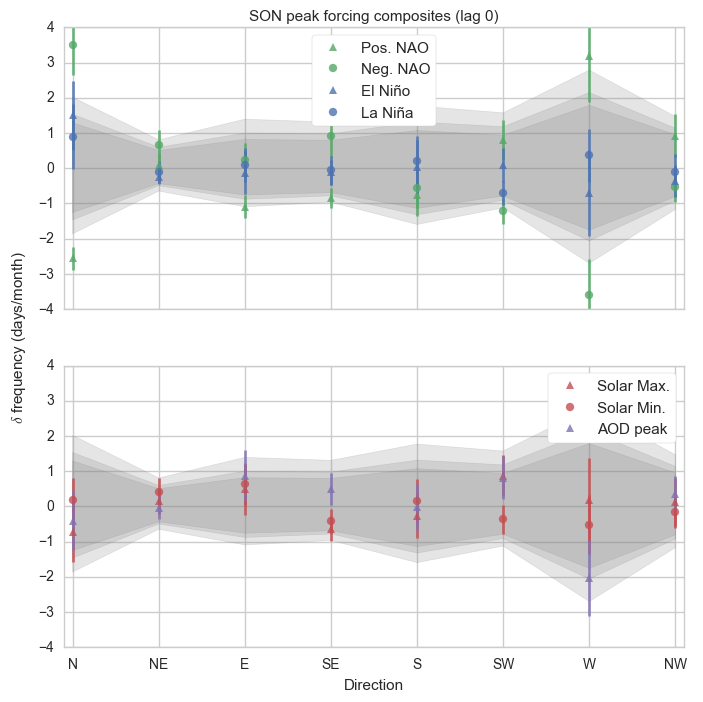

In [53]:
hbgwl.figHorizCompOnePrd(df=son_frame, conf_df= conf_df_son, naoPhase=seasonal_NAO_keys,
                         aod_peak=seasonal_aodPeak_keys, solarPhase=seasonal_SC_keys,
                         ensoPhase=seasonal_ENSO_keys, epoch=0, szn="SON", giveYrange=(-4,4))

In [54]:
son_sig_table = hbgwl.get_pTable(df=son_frame, mc=mc_array_son, aod_peak=seasonal_aodPeak_keys,
                                 solarPhase=seasonal_SC_keys, naoPhase=seasonal_NAO_keys, 
                                 ensoPhase=seasonal_ENSO_keys, seasonal="SON")

print(tabulate(son_sig_table, headers="firstrow",tablefmt='fancygrid')) #fancygrid 

SON          N           NE          E           SE          S           SW          W           NW
-----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Pos. NAO     -2.56±0.32  0.08±0.35   -1.09±0.33  -0.84±0.29  -0.75±0.61  0.81±0.56   3.18±1.30   0.92±0.61
p-val lower  1.46E-08    0.97        0.00        0.02        0.10        0.62        0.08        0.58
p-val mean   1.13E-04    1.26        0.05        0.14        0.40        0.24        0.00        0.19
p-val upper  0.00        0.43        0.26        0.46        0.57        0.05        2.39E-06    0.02
--           --          --          --          --          --          --          --          --
Neg. NAO     3.50±0.85   0.66±0.44   0.24±0.48   0.91±0.60   -0.56±0.57  -1.22±0.36  -3.61±1.04  -0.53±0.43
p-val lower  8.45E-04    0.95        0.77        0.64        0.19        4.64E-04    1.92E-09    0.13
p-val mean   4.08E-06    0.14        0.68        0.14        0.49    

### Year lags in the seasonal data ###

A sequence of plots showing how negative and positive lags over a ±5 year period affects the significance of the results.

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


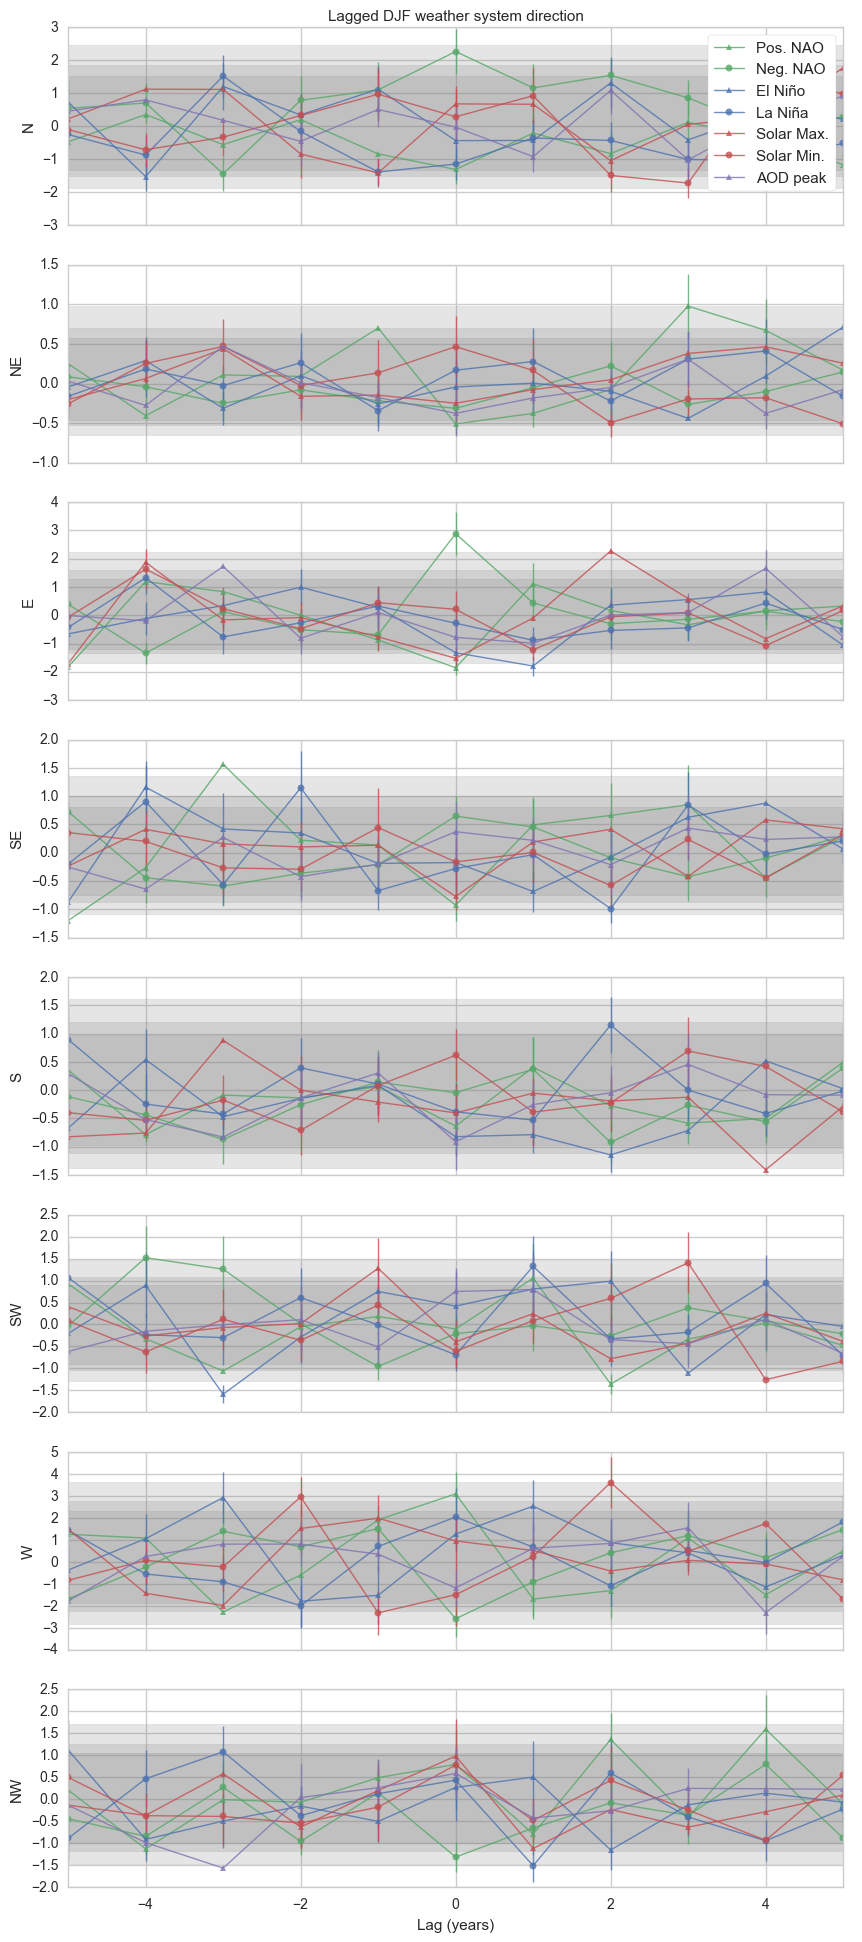

In [55]:
hbgwl.fig_lagged_composite(lags = range(-5,6), szn ="DJF", df=djf_frame, confs= confs_djf, 
                           NAO_keys=seasonal_NAO_keys, ENSO_keys=seasonal_ENSO_keys,
                           SC_keys=seasonal_SC_keys, aodPeak_keys=seasonal_aodPeak_keys)

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


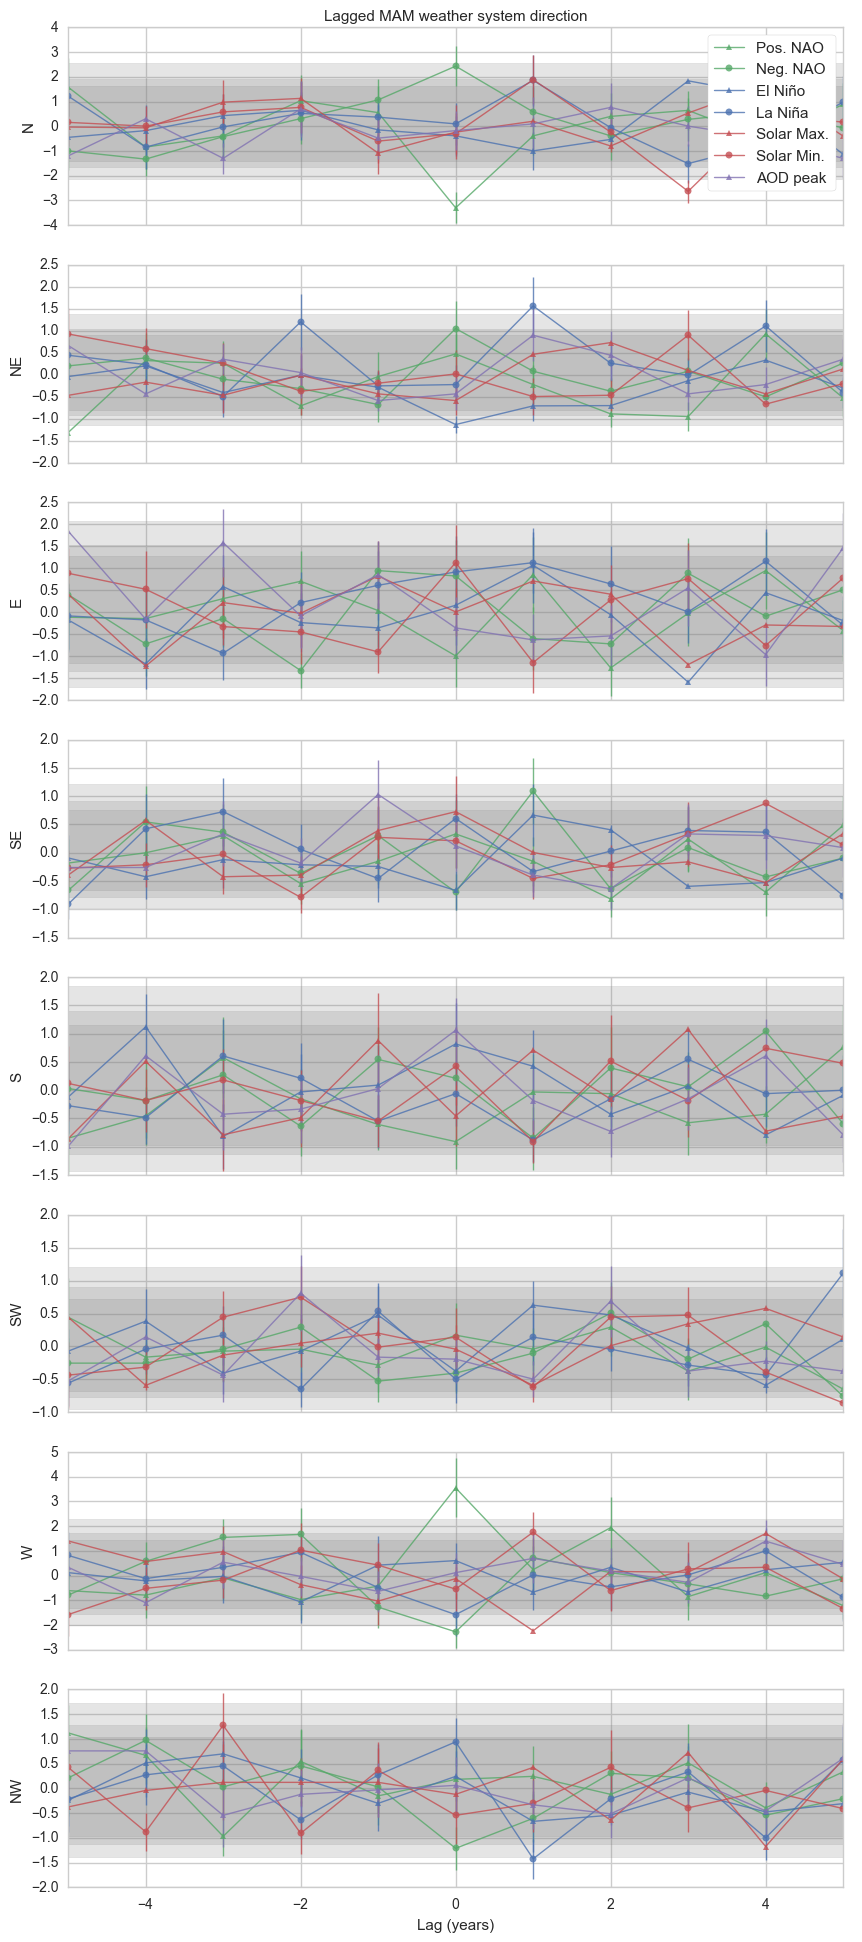

In [56]:
hbgwl.fig_lagged_composite(lags = range(-5,6), szn ="MAM", df=mam_frame, confs= confs_mam, 
                           NAO_keys=seasonal_NAO_keys, ENSO_keys=seasonal_ENSO_keys,
                           SC_keys=seasonal_SC_keys, aodPeak_keys=seasonal_aodPeak_keys)

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


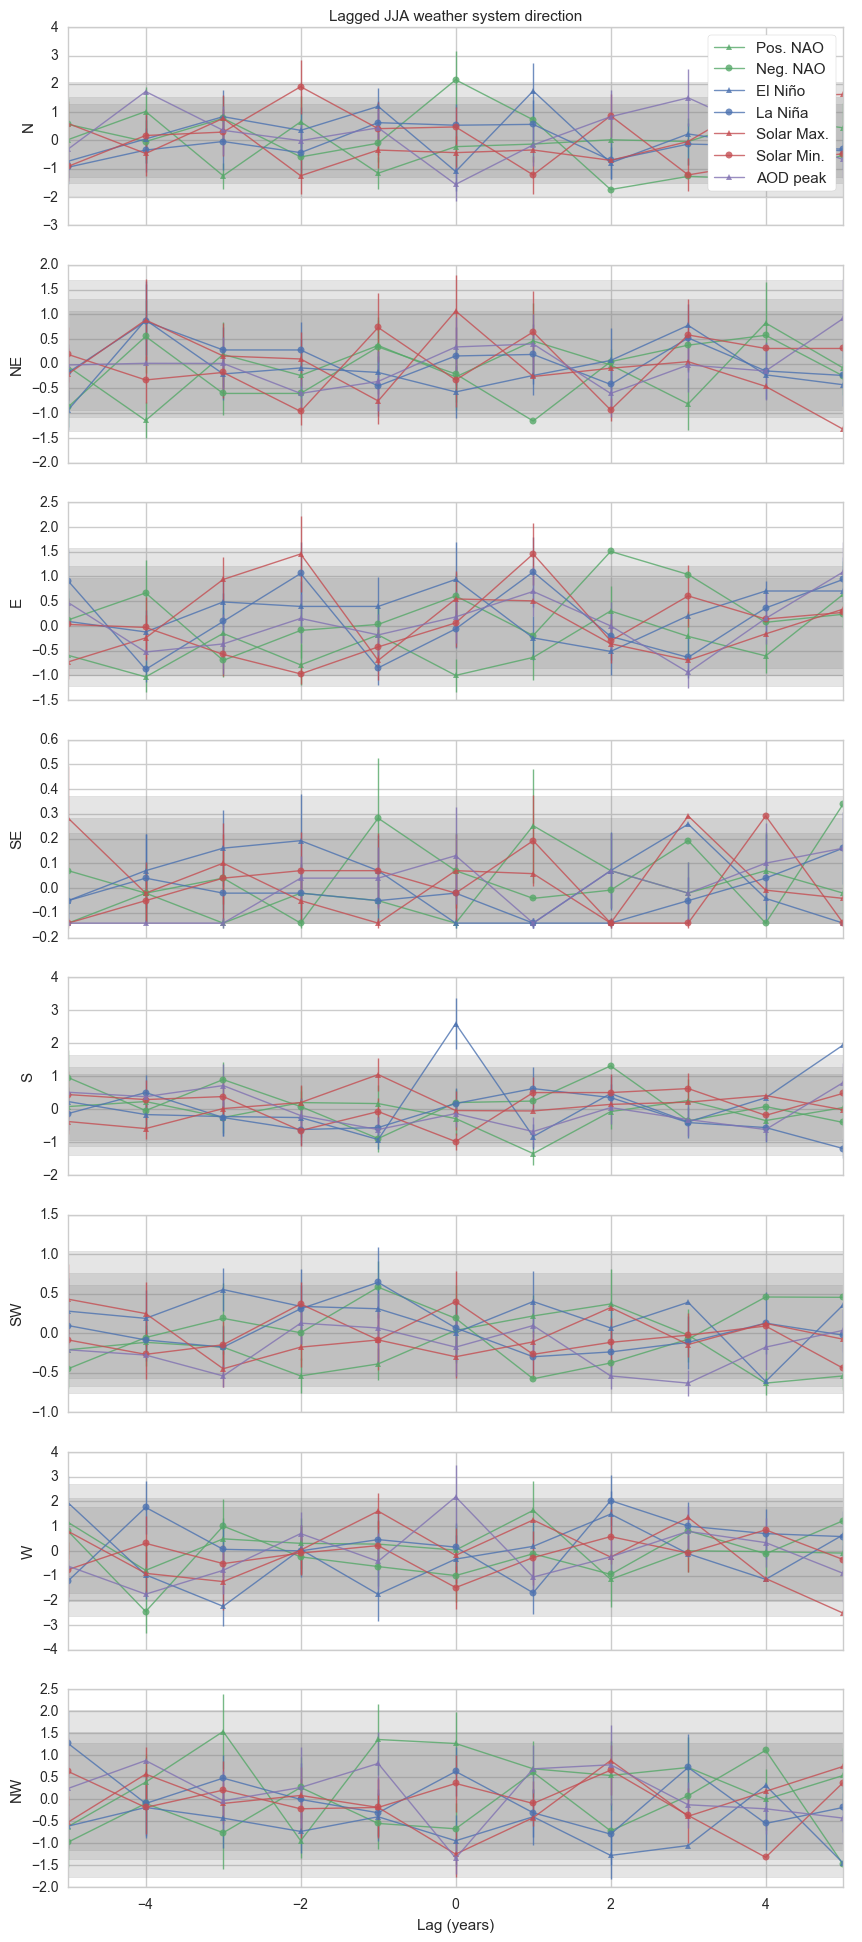

In [57]:
hbgwl.fig_lagged_composite(lags = range(-5,6), szn ="JJA", df=jja_frame, confs= confs_jja, 
                           NAO_keys=seasonal_NAO_keys, ENSO_keys=seasonal_ENSO_keys,
                           SC_keys=seasonal_SC_keys, aodPeak_keys=seasonal_aodPeak_keys)

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


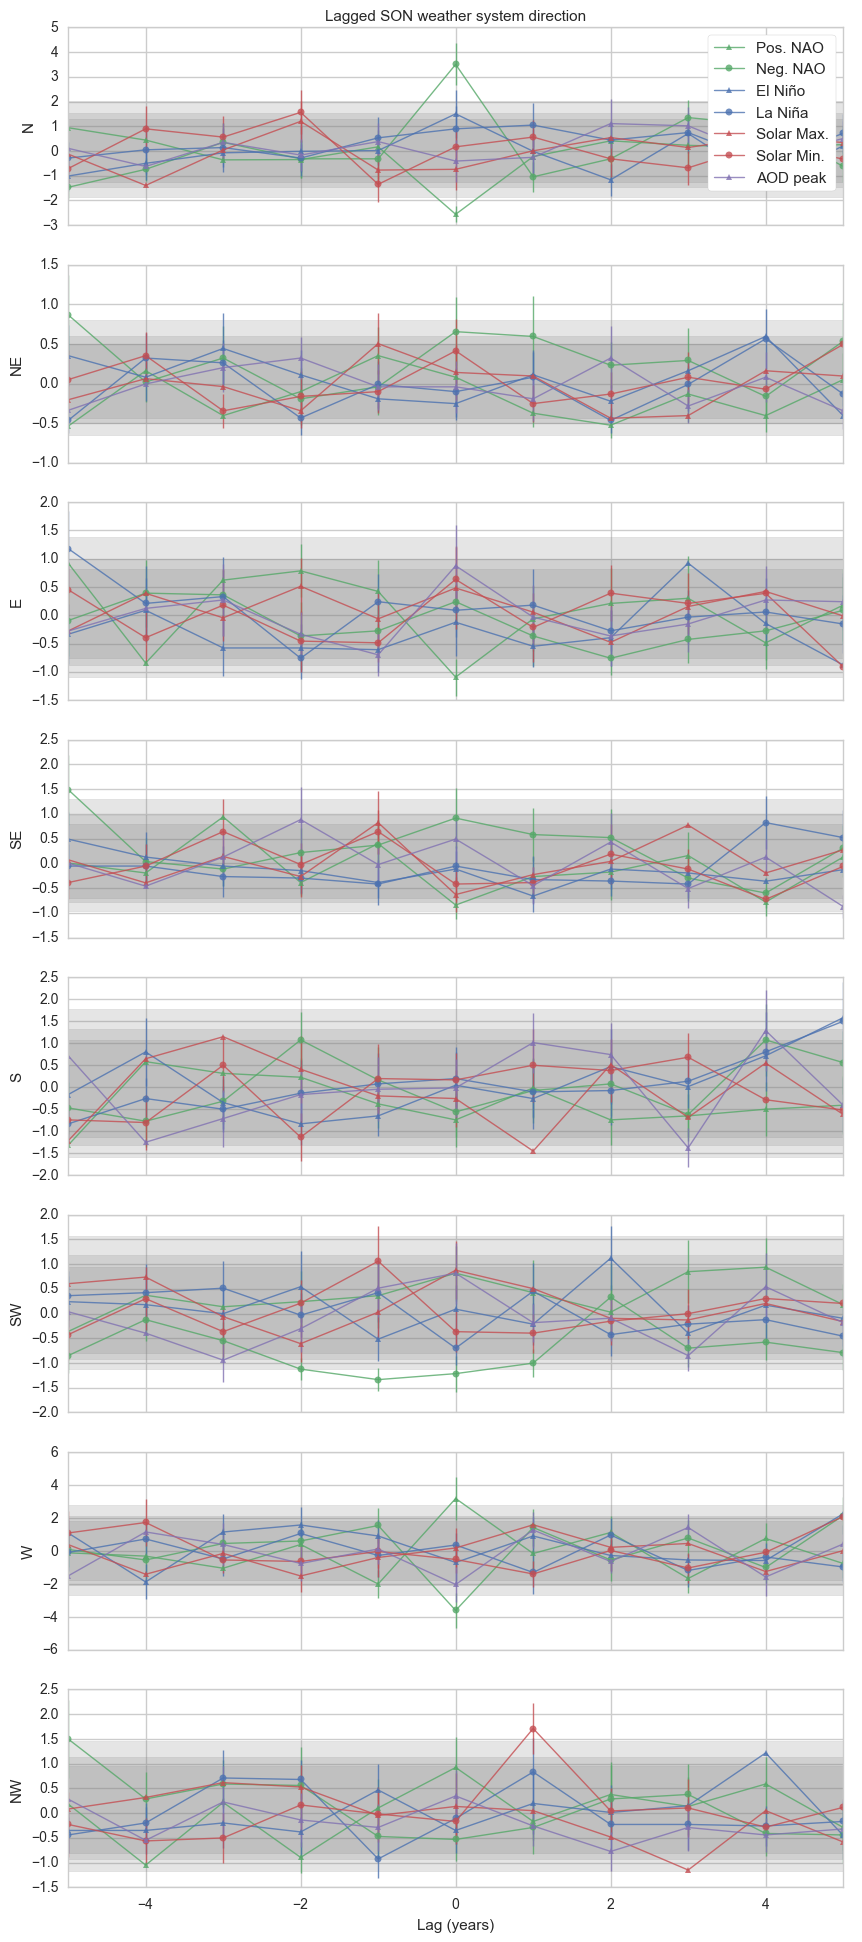

In [58]:
hbgwl.fig_lagged_composite(lags = range(-5,6), szn ="SON", df=son_frame, confs= confs_son, 
                           NAO_keys=seasonal_NAO_keys, ENSO_keys=seasonal_ENSO_keys,
                           SC_keys=seasonal_SC_keys, aodPeak_keys=seasonal_aodPeak_keys)

### Generate restricted plots for the manuscript ### 

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


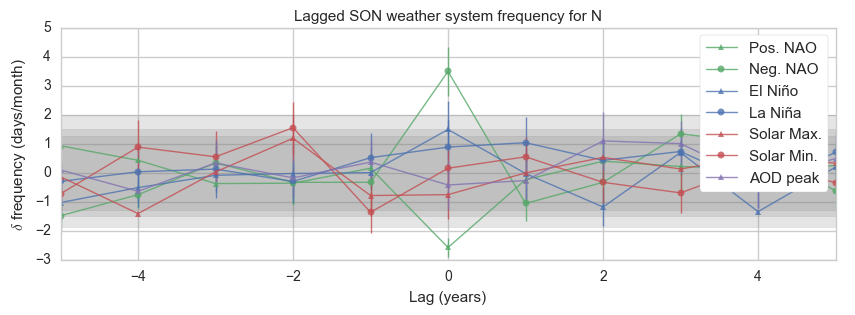

In [59]:
hbgwl.fig_individual_lag_comps(lags = range(-5,6), szn ="SON", df=son_frame, confs= confs_son, 
                           NAO_keys=seasonal_NAO_keys, ENSO_keys=seasonal_ENSO_keys,
                           SC_keys=seasonal_SC_keys, aodPeak_keys=seasonal_aodPeak_keys,
                        get_direction="N")

/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/fperez/usr/conda/envs/ewind/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


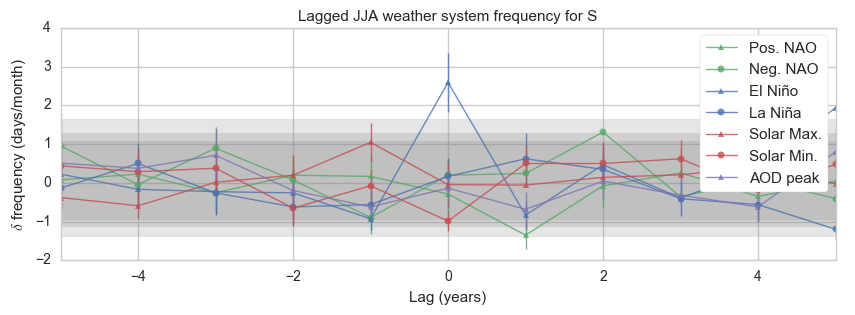

In [60]:
hbgwl.fig_individual_lag_comps(lags = range(-5,6), szn ="JJA", df=jja_frame, confs= confs_jja, 
                           NAO_keys=seasonal_NAO_keys, ENSO_keys=seasonal_ENSO_keys,
                           SC_keys=seasonal_SC_keys, aodPeak_keys=seasonal_aodPeak_keys,
                        get_direction="S")